## Modeling

For the model, I will use Temporal Fusion Transformer from PyTorchForecasting library. This library yields several class and methods to facilitate the work with TimeSeries with excellents results.
Initially, I will use TimeSeriesDataset to create a PyTorch dataset (my TimeSeries) and then use DataLoaders to create batches to  fit the model.</br>
More information about this model can be found: 
[Temporal Fusion Transformer ](https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer.html)

In [36]:
import pandas as pd
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, EncoderNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, MAE, MAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [37]:
data = pd.read_csv('./output/dataset.csv')

data.item_code = data.item_code.astype(str).astype("category")
data.group_ids = data.group_ids.astype(str).astype("category")
data.month = data.month.astype(str).astype("category")

from sklearn.preprocessing import MinMaxScaler
# Normalization of 'quantity'
scaler = MinMaxScaler()
data['quantity_scaled'] = scaler.fit_transform(np.array(data.quantity).reshape(-1,1))
data['min_temp_scaled'] = scaler.fit_transform(np.array(data.min_temp).reshape(-1,1))
data['max_temp_scaled'] = scaler.fit_transform(np.array(data.max_temp).reshape(-1,1))
data['avg_price_scaled'] = scaler.fit_transform(np.array(data.avg_price).reshape(-1,1))

data.head()

,item_code,quantity,avg_price,date,min_temp,max_temp,log_quantity,month,sma4,time_idx,group_ids,quantity_scaled,min_temp_scaled,max_temp_scaled,avg_price_scaled
0,20209,109.0,6.990000,2017-01-01,35.0,76.0,4.691348,1,NaN,0,1,0.111588,0.102041,0.044444,0.332495
1,50215,422.0,9.845294,2017-01-01,35.0,76.0,6.045005,1,NaN,0,3,0.447425,0.102041,0.044444,0.591886
2,70165,471.0,9.458725,2017-01-01,35.0,76.0,6.154858,1,NaN,0,2,0.500000,0.102041,0.044444,0.556767
3,70208,145.0,10.067692,2017-01-01,35.0,76.0,4.976734,1,NaN,0,4,0.150215,0.102041,0.044444,0.612089
4,20209,136.0,7.144666,2017-02-01,42.0,83.0,4.912655,2,NaN,1,1,0.140558,0.244898,0.200000,0.346545


In [38]:
# Create Dataset and Dataloaders
max_encoder_length = 24
max_prediction_length = 6
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],    
    time_idx="time_idx",
    target="quantity",
    #     categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["item_code","group_ids"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=['item_code','group_ids'],
    time_varying_known_categoricals=["month"],
    time_varying_known_reals=["time_idx", "avg_price_scaled"],
    time_varying_unknown_reals=['quantity','avg_price_scaled','min_temp_scaled','max_temp_scaled']
)

# validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [39]:
# # load the first batch
# x, y = next(iter(train_dataloader))
# print("x =", x)
# print("\ny =", y)
# print("\nsizes of x =")
# for key, value in x.items():
#     print(f"\t{key} = {value.size()}")

In [40]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
MAE()(baseline_predictions, actuals)

tensor(140.8333)

In [41]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 19.0k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 120   
3  | prescalers                         | ModuleDict                      | 80    
4  | static_variable_selection          | VariableSelectionNetwork        | 142   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.2 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Restored states from the checkpoint file at G:\My Drive\Projects\python_projects\sales_forecasting\lr_find_temp_model.ckpt


suggested learning rate: 0.06760829753919811


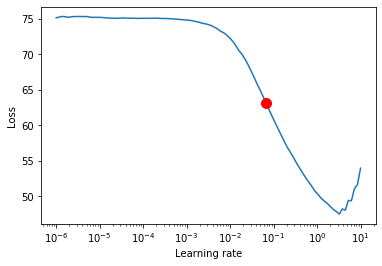

C:\Users\Classico\anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


In [42]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [43]:
# Training the model (TemporalFusionTransformer)

# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(max_epochs=50,
                     min_epochs=5,
                     gpus=0,
                     weights_summary="top",
                     gradient_clip_val=0.1,
                     limit_train_batches= 50,  # coment in for training, running valiation every 30 batches
                     # fast_dev_run=True,  # comment in to check that network or dataset has no serious bugs
                     #     callbacks=[lr_logger, early_stop_callback],
                     logger=logger
                    )


tft_model = TemporalFusionTransformer.from_dataset(training,
                                                   learning_rate=0.040,
                                                   hidden_size=20,
                                                   attention_head_size=1,
                                                   dropout=0.2,
                                                   hidden_continuous_size=8,
                                                   output_size=7,  # 7 quantiles by default
                                                   loss=QuantileLoss(),
                                                   log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
                                                   reduce_on_plateau_patience=4
                                                  )
print(f"Number of parameters in network: {tft_model.size()/1e3:.1f}k")

# Fit the model
trainer.fit(tft_model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Number of parameters in network: 27.3k



   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 120   
3  | prescalers                         | ModuleDict                      | 80    
4  | static_variable_selection          | VariableSelectionNetwork        | 166   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.7 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.5 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.7 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.7 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.7 

1

In [44]:
# Model Evaluation
# Select best model according to loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft_model = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [45]:
# calcualte mean absolute error on validation dataset
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft_model.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(135.8766)

In [46]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft_model.predict(val_dataloader, mode="raw", return_x=True)

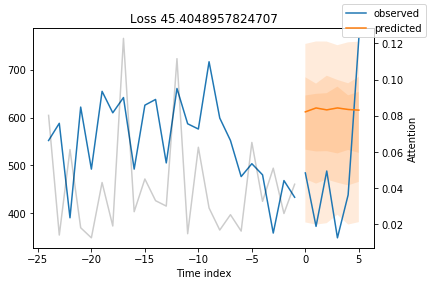

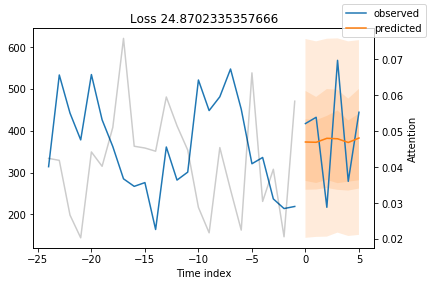

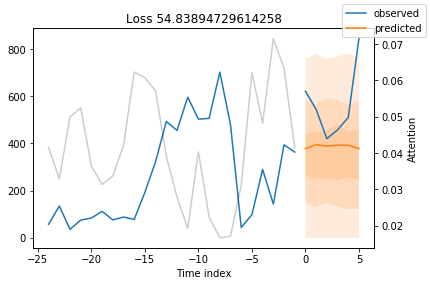

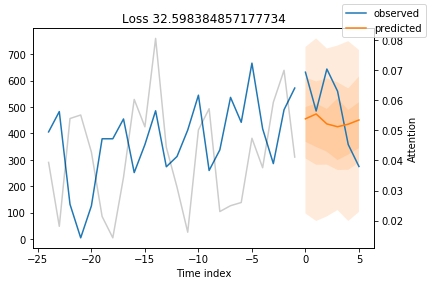

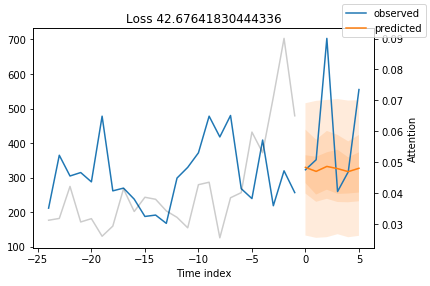

In [47]:
for idx in range(5):  # plot 10 examples
    best_tft_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

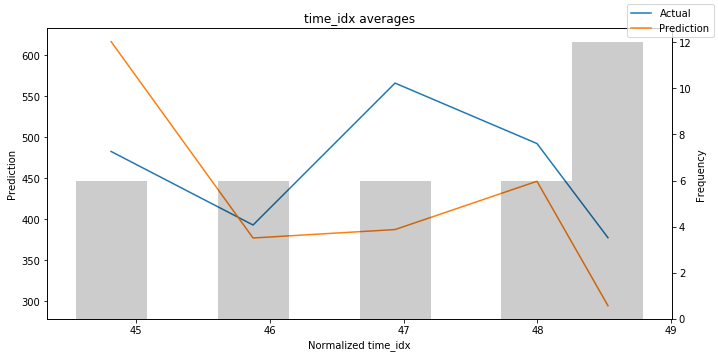

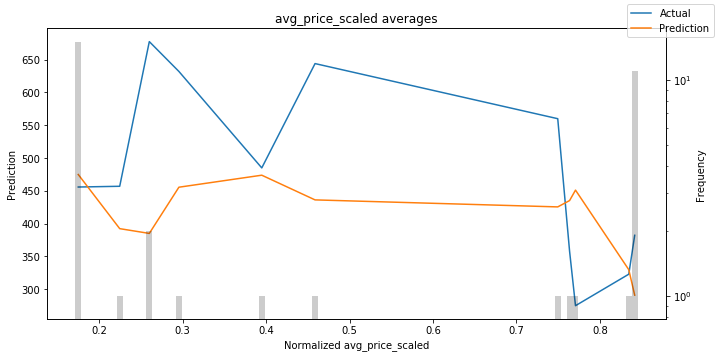

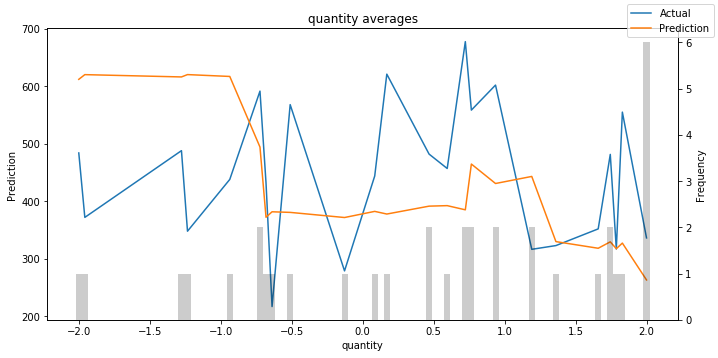

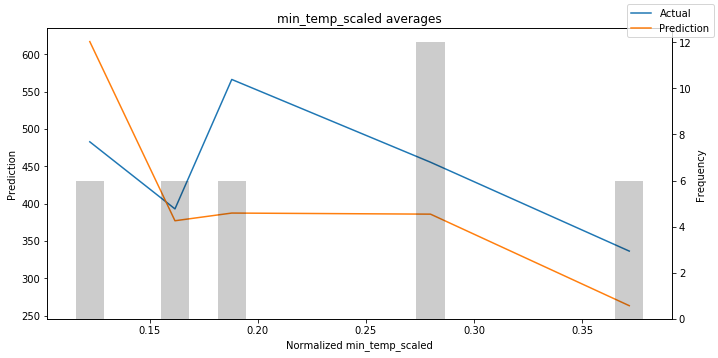

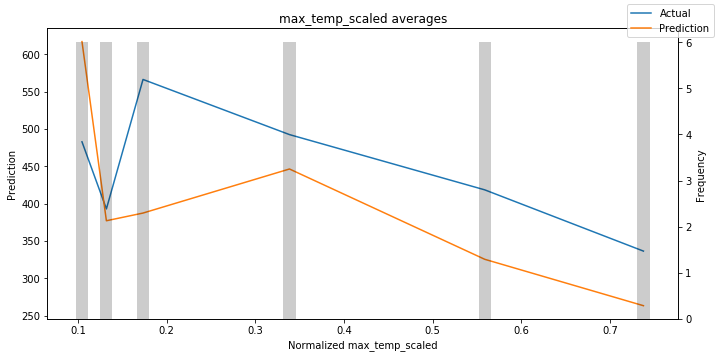

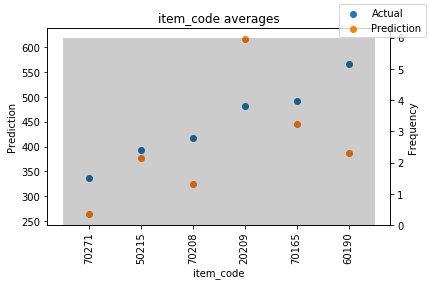

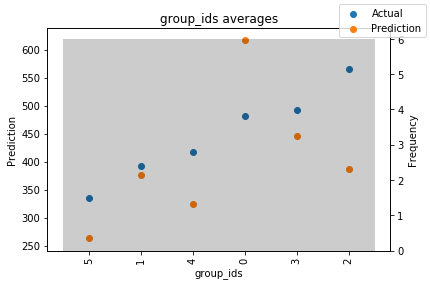

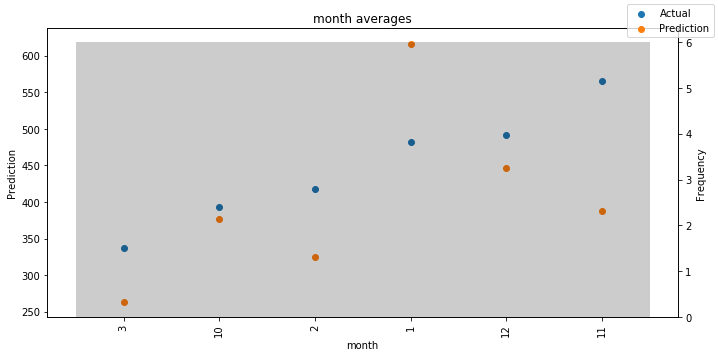

In [48]:
predictions, x = best_tft_model.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft_model.calculate_prediction_actual_by_variable(x, predictions)
best_tft_model.plot_prediction_actual_by_variable(predictions_vs_actuals);

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x180 with 1 Axes>,
 'encoder_variables': <Figure size 504x252 with 1 Axes>,
 'decoder_variables': <Figure size 504x198 with 1 Axes>}

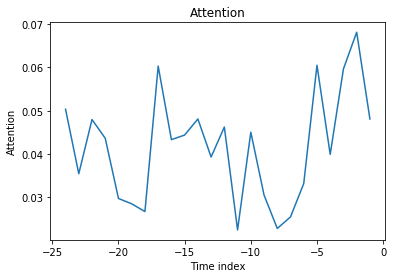

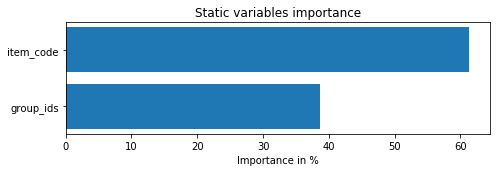

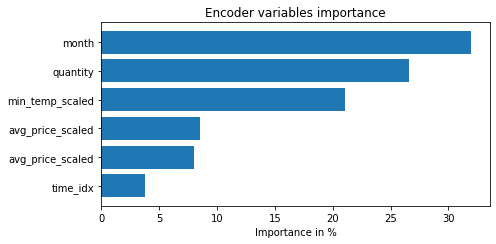

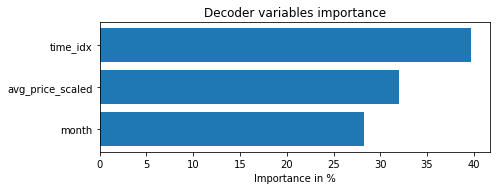

In [49]:
interpretation = best_tft_model.interpret_output(raw_predictions, reduction="sum")
best_tft_model.plot_interpretation(interpretation)

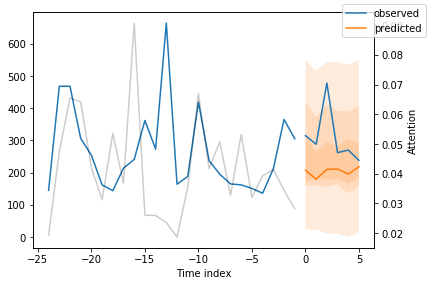

In [62]:
# Predict on Select data
raw_prediction, x = best_tft_model.predict(
    training.filter(lambda x: (x.item_code == "70208") & (x.time_idx_first_prediction == 24)),
    mode="raw",
    return_x=True,
)
best_tft_model.plot_prediction(x, raw_prediction, idx=0);

In [56]:
raw_prediction['prediction']

tensor([[[ 23.1146, 158.6357, 171.7188, 207.5705, 313.0064, 421.5757, 549.7336],
         [ 23.3972, 161.5667, 181.6779, 179.6862, 263.4464, 373.7425, 515.3895],
         [ 11.5632, 154.9623, 177.8811, 210.0148, 295.1909, 409.4949, 543.8528],
         [ 10.4168, 164.3204, 181.3300, 211.5018, 281.5286, 391.6024, 542.3457],
         [  0.0000, 135.2790, 165.8697, 195.4998, 304.7523, 390.3781, 534.5217],
         [ 14.6556, 158.1243, 185.1365, 218.3633, 290.2608, 405.0239, 549.5159]]])

In [52]:
# Convert prediction a normal scale
preds = np.array(raw_prediction['prediction']).reshape(6,7)
preds = scaler.inverse_transform(preds)
preds

array([[ 1224.6855 ,  3213.0188 ,  4739.704  ,  5822.271  ,  7273.109  ,
         8295.896  , 10954.928  ],
       [  982.58124,  3633.748  ,  5074.204  ,  6194.0176 ,  7111.559  ,
         8412.681  , 11036.876  ],
       [ 1234.41   ,  3706.046  ,  4130.349  ,  4578.74   ,  5940.1025 ,
         7881.1025 , 10032.887  ],
       [ 1192.155  ,  3813.1335 ,  4230.3374 ,  4593.8174 ,  5776.891  ,
         7663.904  , 10089.135  ],
       [  957.79004,  3322.5706 ,  3869.756  ,  4331.0317 ,  6302.115  ,
         7529.157  ,  9820.442  ],
       [ 1083.1218 ,  3687.2822 ,  4205.6567 ,  4995.952  ,  6136.0283 ,
         7941.319  , 10419.284  ]], dtype=float32)

In [ ]:
# group_dict = {'60190': 0,
#               '20209': 1,
#               '70165': 2,
#               '50215': 3,
#               '70208': 4,
#               '70271': 5
#              }